# Physics-informed Neural Networks for Burgers' Equation

Inspired from https://maziarraissi.github.io/PINNs/ and corresponding papers
* [Physics Informed Deep Learning (Part I): Data-driven
Solutions of Nonlinear Partial Differential Equations](https://arxiv.org/abs/1711.10561)
* [Physics Informed Deep Learning (Part II): Data-driven
Discovery of Nonlinear Partial Differential Equations](https://arxiv.org/abs/1711.10566)

Burgers' equation is a nonlinear partial differential equation that describes the evolution of a velocity field in a fluid. It is a simplified model of the Navier-Stokes equations, which are used to describe the motion of fluids. Some interesting videos I watched on Navier-Stokes equations are:
* [The million dollar equation (Navier-Stokes equations)](https://youtu.be/Ra7aQlenTb8) - a video created with manim
* [Navier-Stokes Equations - Numberphile](https://youtu.be/ERBVFcutl3M)
* [Why 5/3 is a fundamental constant for turbulence](https://youtu.be/_UoTTq651dE) - A video by 3Blue1Brown
* [Navier Stokes Equation | A Million-Dollar Question in Fluid Mechanics](https://youtu.be/XoefjJdFq6k)
* [Navier-Stokes Equations - 3Blue1Brown](https://youtu.be/1LX0ilDA4E8)

The burgers' equation and its boundary conditions as used by Raissi et al. are:

$$
\begin{array}{l}
u(t, x) : \text{velocity of the fluid at time } t \text{ and position } x,\\
\text{support : } x \in [-1,1],\ \ \ t \in [0,1],\\
\text{constraint : }\frac{\partial u}{\partial t} + u \frac{\partial u}{\partial x} - (0.01/\pi) \frac{\partial^2 u}{\partial x^2} = 0\\
\text{initial \& boundary conditions: } u(0,x) = -\sin(\pi x), \ \ u(t,-1) = u(t,1) = 0
\end{array}
$$

Here, we are going to use a neural network to approximate $u(t, x)$ function.

## Imports

In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = ""

import numpy as np
import scipy
from sklearn.model_selection import train_test_split

import jax
import jax.random as jr
import jax.numpy as jnp

import flax.linen as nn
import optax

import matplotlib.pyplot as plt


from pyDOE2 import lhs

## Inference

Here the task is to use the initial and boundary conditions data to train a neural network to approximate the solution of the PDE. We will use the ground truth data given by Raissi et al. to evaulate the accuracy of the neural network. Here are some pointers:
* [How was the ground truth data generated?](https://github.com/maziarraissi/PINNs/issues/10)
* We will use only 100 data points from initial and boundary conditions to calculate data-driven MSE loss
* We will use 10000 data points randomly sampled from the domain to calculate the constraint MSE loss. Note that we do not need any ground truth data to calculate this loss. 

### Load and visualize Data

X.shape=(100, 256) T.shape=(100, 256) Exact.shape=(100, 256)


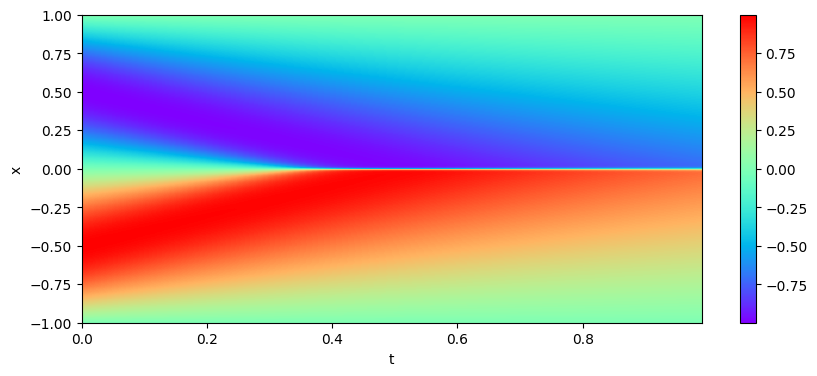

In [2]:
data = scipy.io.loadmat('burgers_shock.mat')
t = data['t'].flatten()[:,None]
x = data['x'].flatten()[:,None]
Exact = np.real(data['usol']).T
X, T = np.meshgrid(x,t)
print(f"{X.shape=} {T.shape=} {Exact.shape=}")

plt.figure(figsize=(10, 4))
plt.imshow(Exact.T, aspect='auto', cmap='rainbow', origin='lower', extent=[t.min(), t.max(), x.min(), x.max()]);
plt.xlabel('t')
plt.ylabel('x')
plt.colorbar();

# plt.scatter(T.ravel(), X.ravel(), c=Exact.ravel(), cmap='coolwarm', s=50);

### Model

In [3]:
class Burgers_NN(nn.Module):
    layers: list
    
    @nn.compact
    def __call__(self, t, x):
        t = 2*t - 1
        X = jnp.concatenate([t.reshape(1,1), x.reshape(1,1)], axis=1)
        
        for num_neurons in self.layers:
            X = nn.Dense(num_neurons)(X)
            X = nn.tanh(X)
        
        y = nn.Dense(1)(X)
        return y.squeeze()

model = Burgers_NN(layers=[2, 20, 20, 20, 20, 20, 20, 20, 20])

### Generate training data

In [4]:
np.random.seed(0)
train_size = 100
collocation_size = 10000

# Boundary data
xb = 2 * lhs(1, train_size//2) - 1 # x in [-1, 1]
tb = np.zeros((train_size//2, 1)) # t = 0
ub = -jnp.sin(jnp.pi * xb) # u(0, x) = -sin(pi*x)

# Initial data
xi = jnp.ones((train_size//2, 1))
xi = xi.at[:len(xi)//2].set(-1)
ti = lhs(1, train_size//2) # t in [0, 1]
ui = jnp.zeros_like(ti) # u(t, 0) = 0

x_train = jnp.concatenate([xb, xi], axis=0).ravel()
t_train = jnp.concatenate([tb, ti], axis=0).ravel()
u_train = jnp.concatenate([ub, ui], axis=0).ravel()

# Collocation points
xc = 2 * lhs(1, collocation_size).ravel() - 1 # x in [-1, 1]
tc = lhs(1, collocation_size).ravel() # t in [0, 1]

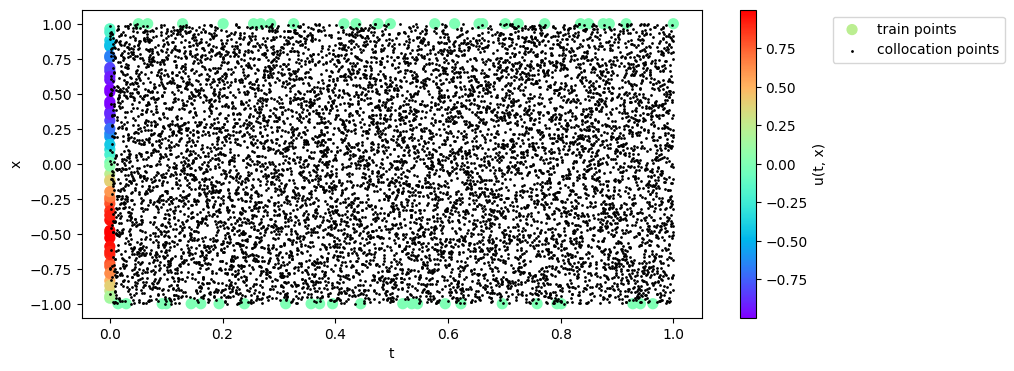

In [5]:
plt.figure(figsize=(10, 4))
plt.scatter(t_train, x_train, c=u_train, cmap='rainbow', s=50, label='train points');
plt.colorbar(label='u(t, x)')
plt.scatter(tc, xc, c='k', s=1, label='collocation points');
plt.xlabel('t')
plt.ylabel('x')
plt.legend(bbox_to_anchor=(1.2, 1), loc='upper left');

In [6]:
def loss_fn(params, constraint=True):
    nn_fn = lambda t, x: model.apply(params, t, x)
    vmap_nn_fn = jax.vmap(nn_fn)
    u_pred = vmap_nn_fn(t_train, x_train)

    print(f"{u_pred.shape=} {u_train.shape=}")
    assert u_pred.shape == u_train.shape
    mse = jnp.mean((u_pred - u_train) ** 2)

    if constraint is True:
        du_dx_fn = jax.grad(nn_fn, argnums=1)
        du_dx = jax.vmap(du_dx_fn)(tc, xc)
        print(f"{du_dx.shape=}")

        du_dt_fn = jax.grad(nn_fn, argnums=0)
        du_dt = jax.vmap(du_dt_fn)(tc, xc)
        print(f"{du_dt.shape=}")

        d2u_dx2_fn = jax.grad(du_dx_fn, argnums=1)
        d2u_dx2 = jax.vmap(d2u_dx2_fn)(tc, xc)
        print(f"{d2u_dx2.shape=}")

        u = vmap_nn_fn(tc, xc)
        f = du_dt + u * du_dx - (0.01/jnp.pi) * d2u_dx2

        mse += jnp.mean(f ** 2)

    return mse

In [7]:
def fit(value_and_grad_fn, init_params, n_iters):
    opt = optax.adam(1e-3)
    init_state = opt.init(init_params)

    @jax.jit
    def one_step(params_and_state, aux):
        params, state = params_and_state

        loss, grads = value_and_grad_fn(params)

        updates, state = opt.update(grads, state)
        params = optax.apply_updates(params, updates)

        return (params, state), loss

    params_and_state = (init_params, init_state)
    (params, state), loss_history = jax.lax.scan(one_step, params_and_state, None, length=n_iters)
    return params, loss_history

Training with constraint
u_pred.shape=(100,) u_train.shape=(100,)
du_dx.shape=(10000,)
du_dt.shape=(10000,)
d2u_dx2.shape=(10000,)
Training without constraint
u_pred.shape=(100,) u_train.shape=(100,)


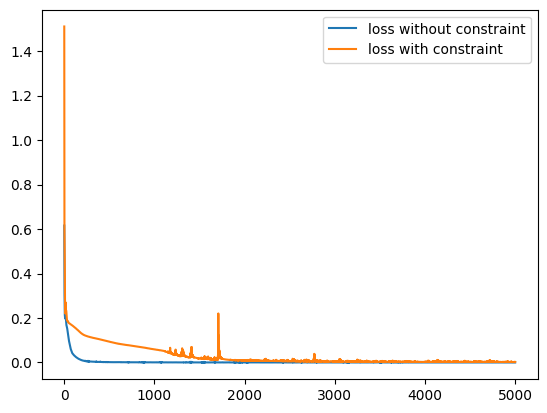

In [8]:
key = jr.PRNGKey(3)
init_params = model.init(key, t_train[0], x_train[0])
n_iters = 5000

print("Training with constraint")
value_and_grad_fn = jax.value_and_grad(lambda params: loss_fn(params, constraint=True))
c_params, c_loss_history = fit(value_and_grad_fn, init_params, n_iters=n_iters)

print("Training without constraint")
value_and_grad_fn = jax.value_and_grad(lambda params: loss_fn(params, constraint=False))
params, loss_history = fit(value_and_grad_fn, init_params, n_iters=n_iters)

plt.plot(loss_history, label='loss without constraint')
plt.plot(c_loss_history, label='loss with constraint');
plt.legend();

In [9]:
params_list = [c_params, params]
labels = ['with constraint', 'without constraint']
pred_fn = jax.jit(jax.vmap(model.apply, in_axes=(None, 0, 0)))

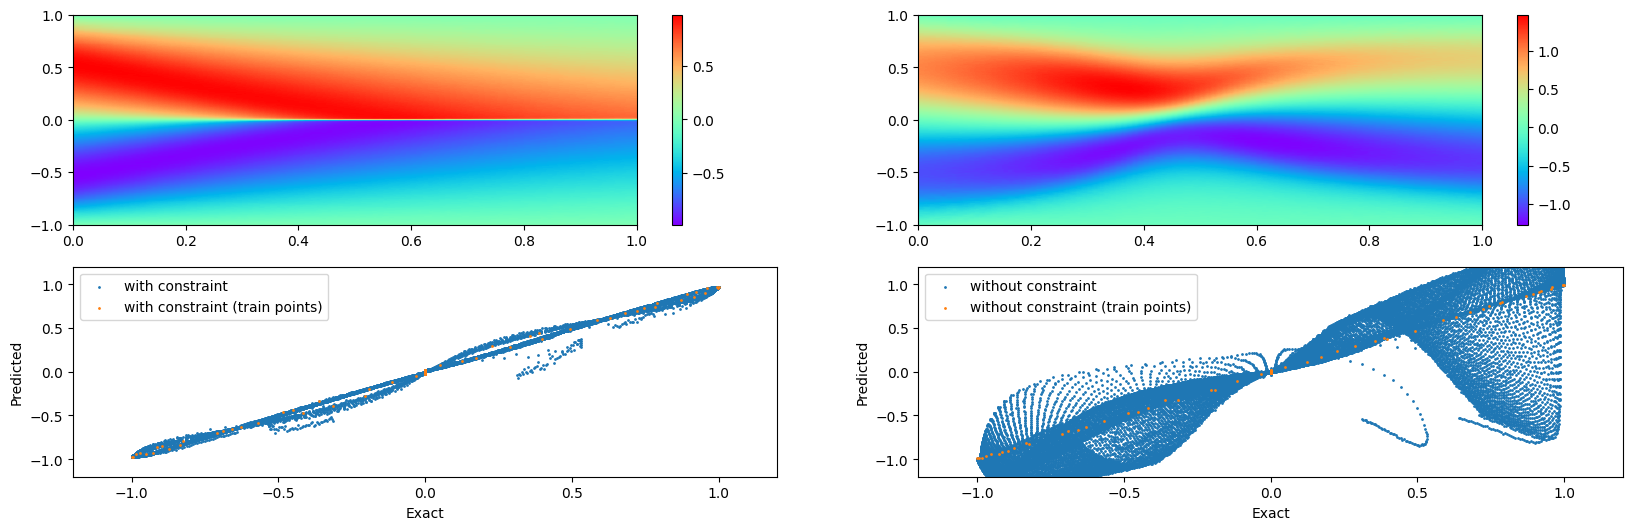

In [10]:
fig, ax = plt.subplots(2, 2, figsize=(20, 6))
for idx, (tmp_params, label) in enumerate(zip(params_list, labels)):
    u_pred = pred_fn(tmp_params, T.ravel(), X.ravel())
    u_pred_train = pred_fn(tmp_params, t_train, x_train)

    mappable = ax[0, idx].imshow(u_pred.reshape(100, 256).T, cmap='rainbow', extent=[0, 1, -1, 1], aspect='auto')
    fig.colorbar(mappable, ax=ax[0, idx])
    ax[1, idx].scatter(Exact.ravel(), u_pred, s=1, label=label);
    ax[1, idx].scatter(u_train, u_pred_train, s=1, label=f'{label} (train points)')
    ax[1, idx].legend()
    ax[1, idx].set_xlabel('Exact')
    ax[1, idx].set_ylabel('Predicted')
    ax[1, idx].set_ylim(-1.2, 1.2)
    ax[1, idx].set_xlim(-1.2, 1.2)

### Sliced prediction

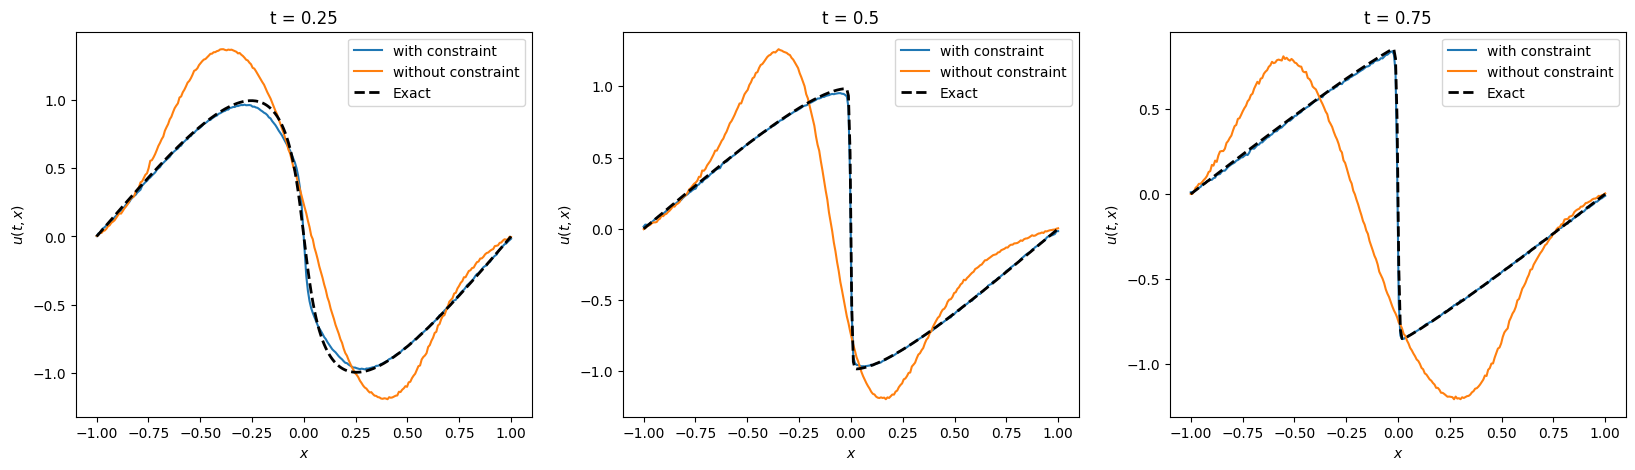

In [19]:
fig, ax = plt.subplots(1, 3, figsize=(20, 5))
for axes, t_val in zip(ax, [0.25, 0.50, 0.75]):
    x = X.ravel()[T.ravel()==t_val]
    t = jnp.ones_like(x) * t_val
    u = Exact.ravel()[T.ravel()==t_val]
    for tmp_params, label in zip(params_list, labels):
        pred_u = pred_fn(tmp_params, t, x)
        axes.plot(x, pred_u, label=label)
    axes.plot(x, u, label='Exact', c='k', linestyle='--', linewidth=2)
    axes.set_title(f't = {t_val}')
    axes.set_xlabel('$x$')
    axes.set_ylabel('$u(t, x)$')
    axes.legend();

### Metrics

In [12]:
c_pred_u = pred_fn(c_params, T.ravel(), X.ravel())
pred_u = pred_fn(params, T.ravel(), X.ravel())

print(f"RMSE (constrained)= {np.sqrt(np.mean((Exact.ravel() - c_pred_u.ravel())**2)):0.4f}")
print(f"RMSE (unconstrained)= {np.sqrt(np.mean((Exact.ravel() - pred_u.ravel())**2)):0.4f}")

RMSE (constrained)= 0.0290
RMSE (unconstrained)= 0.3646


### Extrapolate

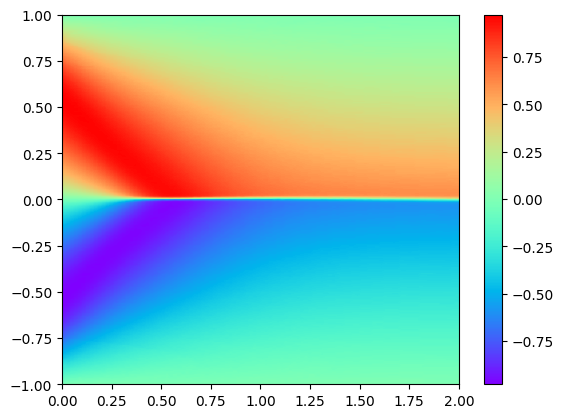

In [13]:
t_extra = jnp.linspace(0, 2, 100)
x_extra = jnp.linspace(-1, 1, 256)
T_extra, X_extra = jnp.meshgrid(t_extra, x_extra)

u_pred = pred_fn(c_params, T_extra.ravel(), X_extra.ravel())

plt.imshow(u_pred.reshape((100, 256), order='F').T, cmap='rainbow', extent=[T_extra.min(), T_extra.max(), X_extra.min(), X_extra.max()], aspect='auto')
plt.colorbar();